# Tow approaches to passing ratio of mDOM to pDOM

Passing ratio is defined by $\frac{1-\eta_{mDOM}}{1-\eta_{pDOM}}$ with $\eta_x$ to veto efficiency of Optical Module $x$.

In [225]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import special
import matplotlib.pyplot as plt
#import warnings
#warnings.filterwarnings('ignore')

Custom logsumexp function from Thorsten:

In [262]:
import decimal as dc

#dc.getcontext().prec = 28
#print(dc.getcontext().prec)

def custom_logsumexp_high_prec(logs, signs):
    positive_mask = signs > 0

    #print type(positive_mask)
    #print numpy.array(logs)
    positive_logs = np.array([dc.Decimal(log) for log in logs])[positive_mask]
    negative_logs = np.array([dc.Decimal(log) for log in logs])[positive_mask == False]
    res_pos = dc.Decimal(0.0)
    res_neg = None
    if(len(positive_logs) > 0):
        res_pos = dc.Decimal(max(positive_logs)) + dc.Decimal(sum([(dc.Decimal(i) - max(positive_logs)).exp() for i in positive_logs])).ln()
        
    if(len(negative_logs) > 0):
        res_neg = dc.Decimal(max(negative_logs)) + dc.Decimal(sum([(dc.Decimal(i) - max(negative_logs)).exp() for i in negative_logs])).ln()
           
    #print "respos/resneg", res_pos, res_neg
    
    if(res_neg is None):
        
        return res_pos, 1.0
   
    if(res_pos == res_neg):
        print("not enough precision!!!...")
        exit(-1)
        return None, None
    elif(res_pos == res_neg and res_pos == 0):
        print("0?!")
        print(logs)
        exit(-1)
    if(res_neg < res_pos):
        #print("neg < pos")
        ## easy case .. subtracted number is smaller 
        return res_neg + ((res_pos - res_neg).exp() - 1).ln(), 1.0
    else:
        ## A-B < 0 -> A-B = - (B-A) 
        return res_pos + ((res_neg - res_pos).exp() - 1).ln(), -1.0

Function checking if number is even.

In [263]:
def is_even(num):
    return num % 2 == 0

Function giving logarithm of binomial coefficient (a take b).

In [264]:
def binomln(a, b):
    return sp.special.gammaln(a+1) - sp.special.gammaln(b+1) - sp.special.gammaln(a-b+1)

Function giving for a set of veto efficiencies ($\texttt{etas}$) and set of #veto hits ($\texttt{v}$) and # all hits ($\texttt{a}$) the beta distribution of $\eta$.

In [265]:
def prob_dist_beta(eta, v, a):
    return np.exp((v-1)*np.log(eta) + (a-v-1)*np.log(1-eta) - (sp.special.betaln(v, a-v)))

## <font color='orange'>Analytical approach</font>
The two cases ($0<w\leq1$ and $w\geq1$) of hypergeometric functions that will be used below ($1 - \beta_i$ are non-positive). (see page 40, Yudell L. Luke, 1969)

${}_2F_1(\alpha_1 + \alpha_2, 1-\beta_1; \alpha_1 + \alpha_2 + \beta_2; w) = \sum_{n=0}^{\beta_1-1}(-1)^n \begin{pmatrix} \beta_1-1 \\ n\end{pmatrix} \frac{(\alpha_1+\alpha_2+n-1)!\cdot(\alpha_1+\alpha_2+\beta_2-1)!}{(\alpha_1+\alpha_2+\beta_2+n-1)!\cdot(\alpha_1+\alpha_2-1)!} w^n$ for $w<1$

${}_2F_1(\alpha_1 + \alpha_2, 1-\beta_2; \alpha_1 + \alpha_2 + \beta_1; \frac{1}{w}) = \sum_{n=0}^{\beta_2-1}(-1)^n \begin{pmatrix} \beta_2-1 \\ n\end{pmatrix} \frac{(\alpha_1+\alpha_2+n-1)!\cdot(\alpha_1+\alpha_2+\beta_1-1)!}{(\alpha_1+\alpha_2+\beta_1+n-1)!\cdot(\alpha_1+\alpha_2-1)!} \left(\frac{1}{w}\right)^n$ for $w\geq1$

The results for even and odd $n$ are stored separated and substracted in the end each. For purpose of further implementation define the $\log({_2F_1})$.

In [303]:
def log_hyper_2_F_1_below_1(a1, a2, b1, b2, w):
    ln_results_even = []
    ln_results_odd = []
    for n in range(int(b1)):
        ln_resu = binomln(b1-1, n) + sp.special.gammaln(a1+a2+n) + sp.special.gammaln(a1+a2+b2) - sp.special.gammaln(a1+a2+b2+n) - sp.special.gammaln(a1+a2) + n * np.log(w)
        if is_even(n):
            ln_results_even.append(ln_resu)
        else:
            ln_results_odd.append(ln_resu)
    if len(ln_results_odd) == 0:
        ln_results_odd_partsum = -np.inf
    else:
        #ln_results_odd_partsum = sp.special.logsumexp(ln_results_odd)
        ln_results_odd_partsum = custom_logsumexp_high_prec(np.array(ln_results_odd), np.ones_like(ln_results_odd))[0]
    #ln_results_even_partsum = sp.special.logsumexp(ln_results_even)
    ln_results_even_partsum = custom_logsumexp_high_prec(np.array(ln_results_even), np.ones_like(ln_results_even))[0]
    #ln_result = sp.special.logsumexp([ln_results_even_partsum, ln_results_odd_partsum], b=[1,-1])
    ln_result = float(custom_logsumexp_high_prec(np.array([ln_results_even_partsum, ln_results_odd_partsum]), np.array([1, -1]))[0])
    return ln_result

def log_hyper_2_F_1_above_1(a1, a2, b1, b2, w):
    ln_results_even = []
    ln_results_odd = []
    for n in range(int(b2)):
        ln_resu = binomln(b2-1, n) + sp.special.gammaln(a1+a2+n) + sp.special.gammaln(a1+a2+b1) - sp.special.gammaln(a1+a2+b1+n) - sp.special.gammaln(a1+a2) - n * np.log(w)
        if is_even(n):
            ln_results_even.append(ln_resu)
        else:
            ln_results_odd.append(ln_resu)
    if len(ln_results_odd) == 0:
        ln_results_odd_partsum = -np.inf
    else:
        ln_results_odd_partsum = custom_logsumexp_high_prec(np.array(ln_results_odd), np.ones_like(ln_results_odd))[0]
        #ln_results_odd_partsum = sp.special.logsumexp(ln_results_odd)
    #ln_results_even_partsum = sp.special.logsumexp(ln_results_even)
    ln_results_even_partsum = custom_logsumexp_high_prec(np.array(ln_results_even), np.ones_like(ln_results_even))[0]
    #ln_result = sp.special.logsumexp([ln_results_even_partsum, ln_results_odd_partsum], b=[1,-1])
    ln_result = float(custom_logsumexp_high_prec(np.array([ln_results_even_partsum, ln_results_odd_partsum]), np.array([1, -1]))[0])
    return ln_result

Visualization of strange behaviour of hypergeometric function for large numbers near w=1

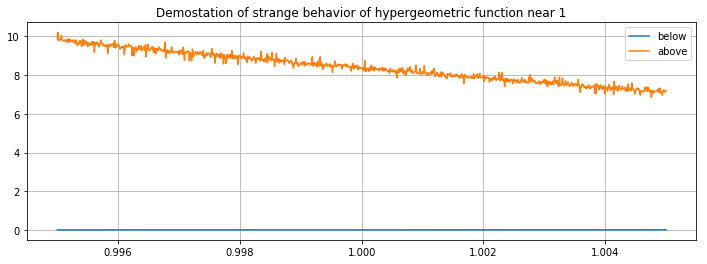

In [290]:
iu = np.linspace(0.995, 1.005, 1001)
a1 = 44
a2 = 34
b1 = 64
b2 = 74
piub = [np.exp(log_hyper_2_F_1_below_1(a1, a2, b1, b2, viu)) for viu in iu]
piua = [np.exp(log_hyper_2_F_1_above_1(a1, a2, b1, b2, viu)) for viu in iu]

plt.rcParams['figure.figsize'] = (12, 4)
plt.title('Demostation of strange behavior of hypergeometric function near 1')
plt.plot(iu, piub, label = 'below')
plt.plot(iu, piua, label = 'above')
plt.legend()
plt.grid('True')
plt.show()

Test for the 'w=1' case. There actually both values of the two cases should give the same results since the distribution is assumed to be continuous.

In [291]:
''' Test for the w=1 case'''
a1, a2, b1, b2, wi = 52, 56, 70, 70, 1
lnA = sp.special.betaln(a1, b1) + sp.special.betaln(a2, b2)
aa = np.exp(sp.special.betaln(a1+a2, b2) + (a1-1) * np.log(wi) + log_hyper_2_F_1_below_1(a1, a2, b1, b2, wi) - lnA)
bb = np.exp(sp.special.betaln(a1+a2, b1) - (a2+1) * np.log(wi) + log_hyper_2_F_1_above_1(a1, a2, b1, b2, wi) - lnA)
if aa != bb:
    print('Argh!')
print(aa - bb)

0.0


Here, finally, apply the hypergeometric functions in the quotien distribution (see T. Pham-Gia, 2000):

$f(w) = B(\alpha_1 + \alpha_2, \beta_2) \cdot w^{\alpha_1 - 1} \cdot \frac{{}_2F_1(\alpha_1 + \alpha_2, 1 - \beta_1; \alpha_1 + \alpha_2 + \beta_2; w)}{B(\alpha_1, \beta_1) \cdot B(\alpha_2, \beta_2)}$ for $0 < w \leq 1$

$f(w) = B(\alpha_1 + \alpha_2, \beta_1) \cdot w^{-(1 + \alpha_2)} \cdot \frac{{}_2F_1(\alpha_1 + \alpha_2, 1 - \beta_2; \alpha_1 + \alpha_2 + \beta_1; \frac{1}{w})}{B(\alpha_1, \beta_1) \cdot B(\alpha_2, \beta_2)}$ for $w \geq 1$

In [292]:
def pdf_ratio(a1, a2, b1, b2, w):
    lnA = sp.special.betaln(a1, b1) + sp.special.betaln(a2, b2)
    def pdf_calc(wi):
        if wi < 0:
            print('Ratio below Zero! Not reasonable!')
            exit(0)
        elif wi == 0:
            resulti = 0
        elif wi < 1:
            resulti = np.exp(sp.special.betaln(a1+a2, b2) + (a1-1) * np.log(wi) + log_hyper_2_F_1_below_1(a1, a2, b1, b2, wi) - lnA)
        else:
            resulti = np.exp(sp.special.betaln(a1+a2, b1) - (1+a2) * np.log(wi) + log_hyper_2_F_1_above_1(a1, a2, b1, b2, wi) - lnA)
        return resulti
    if isinstance(w, int) or isinstance(w, float):
        result = pdf_calc(w)
    else:
        result = np.zeros(len(w))
        for j in range(len(w)):
            wj = w[j]
            result[j] = pdf_calc(wj)
    return result

Change the argument, such that $\texttt{veto hits}$ and $\texttt{all hits}$ give the distribution of the passing ratio $\frac{1-\frac{v_1}{a_1}}{1-\frac{v_2}{a_2}}$. In practice $a_1 = a_2$.

In [293]:
def custom_pdf_ratio(v1, v2, a1, a2, w):
    '''vi / ai here are the number of vetoed / all events for module i'''
    return pdf_ratio(a1-v1, a2-v2, v1, v2, w)

For the cumulative distribution I need the hypergeometric $_3F_2$ function:

In [294]:
def log_hyper_3_F_2_below_1(a1, a2, b1, b2, w):
    a1, a2, b1, b2 = con_int(a1), con_int(a2), con_int(b1), con_int(b2)
    ln_results_even = np.array([])
    ln_results_odd = np.array([])
    for n in range(b1):
        ln_resu = binomln(b1-1, n) + sp.special.gammaln(a1+n) + sp.special.gammaln(a1+a2+n) + sp.special.gammaln(a1+1) + sp.special.gammaln(a1+a2+b2) - sp.special.gammaln(a1) - sp.special.gammaln(a1+a2) - sp.special.gammaln(a1+n+1) - sp.special.gammaln(a1+a2+b2+n) + n * np.log(w)
        if is_even(n):
            ln_results_even = np.append(ln_results_even, ln_resu)
        else:
            ln_results_odd = np.append(ln_results_odd, ln_resu)
    if len(ln_results_odd) == 0:
        ln_results_odd_partsum = -np.inf
    else:
        ln_results_odd_partsum = sp.special.logsumexp(ln_results_odd)
    ln_results_even_partsum = sp.special.logsumexp(ln_results_even)
    ln_result = sp.special.logsumexp([ln_results_even_partsum, ln_results_odd_partsum], b = [1, -1])
    return ln_result

def log_hyper_3_F_2_above_1(a1, a2, b1, b2, w):
    a1, a2, b1, b2 = con_int(a1), con_int(a2), con_int(b1), con_int(b2)
    ln_results_even = np.array([])
    ln_results_odd = np.array([])
    for n in range(b2):
        ln_resu = binomln(b2-1, n) + sp.special.gammaln(a2+n) + sp.special.gammaln(a1+a2+n) + sp.special.gammaln(a2+1) + sp.special.gammaln(a1+a2+b1) - sp.special.gammaln(a2) - sp.special.gammaln(a1+a2) - sp.special.gammaln(a2+n+1) - sp.special.gammaln(a1+a2+b1+n) - n * np.log(w)
        if is_even(n):
            ln_results_even = np.append(ln_results_even, ln_resu)
        else:
            ln_results_odd = np.append(ln_results_odd, ln_resu)
    if len(ln_results_odd) == 0:
        ln_results_odd_partsum = -np.inf
    else:
        ln_results_odd_partsum = sp.special.logsumexp(ln_results_odd)
    ln_results_even_partsum = sp.special.logsumexp(ln_results_even)
    ln_result = sp.special.logsumexp([ln_results_even_partsum, ln_results_odd_partsum], b = [1, -1])
    return ln_result

The integral of the quotient distribution given above. Here I need to use

$\int w^{a_1 - 1} {}_2F_1(a_1 + a_2, 1 - b_1; a_1 + a_2 + b_2; w)\,\mathrm{d}w = \frac{w^{a_1}}{a_1}\cdot {}_3F_2(a_1, a_1 + a_2, 1 - b_1; a_1 + 1, a_1 + a_2 + b_2; w)$

and

$\int w^{-(1 + a_2)} {}_2F_1(a_1 + a_2, 1 - b_2; a_1 + a_2 + b_1; \frac{1}{w})\,\mathrm{d}w = -\frac{w^{-a_2}}{a_2}\cdot {}_3F_2(a_2, a_1 + a_2, 1 - b_2; a_2 + 1, a_1 + a_2 + b_1; \frac{1}{w})$

In [295]:
def cumulative_pdf_ratio(a1, a2, b1, b2, w):
    lnA = sp.special.betaln(a1, b1) + sp.special.betaln(a2, b2)
    def cum_pdf_calc(wi):
        if wi < 0:
            print('Ratio below Zero! Not reasonable!')
            exit(0)
        elif wi == 0:
            resulti = 0
        elif wi < 1:
            resulti = np.exp(sp.special.betaln(a1+a2, b2) + a1 * np.log(wi) - np.log(a1) + log_hyper_3_F_2_below_1(a1, a2, b1, b2, wi) - lnA)
        else:
            resulti = 1 - np.exp(sp.special.betaln(a1+a2, b1) - a2 * np.log(wi) - np.log(a2) + log_hyper_3_F_2_above_1(a1, a2, b1, b2, wi) - lnA)
        return resulti
    if isinstance(w, int) or isinstance(w, float):
        result = cum_pdf_calc(w)
    else:
        result = np.zeros(len(w))
        for j in range(len(w)):
            wj = w[j]
            result[j] = cum_pdf_calc(wj)
    return result

Change the argument, such that $\texttt{veto hits}$ and $\texttt{all hits}$ give the distribution of the passing ratio $\frac{1-\frac{v_1}{a_1}}{1-\frac{v_2}{a_2}}$. In practice $a_1 = a_2$.

In [296]:
def custom_cumulative_pdf_ratio(v1, v2, a1, a2, w):
    '''vi / ai here are the number of vetoed / all events for module i'''
    return cumulative_pdf_ratio(a1-v1, a2-v2, v1, v2, w)

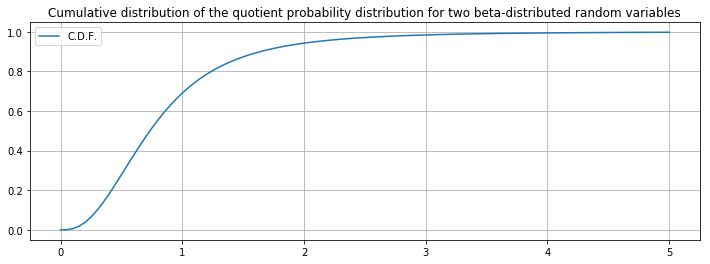

In [297]:
asd = np.linspace(0, 5, 101)
casd = cumulative_pdf_ratio(3, 4, 7, 6, asd)
plt.title('Cumulative distribution of the quotient probability distribution for two beta-distributed random variables')
plt.plot(asd, casd, label = 'C.D.F.')
plt.grid('true')
plt.legend(loc = 'best')
#plt.savefig('cdf.png')
plt.show()

So far all the definitions and tests.

---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------

Now the application.

On a certain interval (e.g. [0, 3]) plot the quotient distribution with indicated expected mean (from raw calculation $\frac{1-\frac{v_1}{a_1}}{1-\frac{v_2}{a_2}}$) and directly obtained mean (via integrating the distribution).

In [302]:
n_veto_hits_mdom = 8
n_veto_hits_pdom = 6
n_hits = 10

/usr/local/lib/python3.5/dist-packages/scipy/special/_logsumexp.py:118: RuntimeWarning: invalid value encountered in log
  out = np.log(s)


Expectation value via integration: 0.977938446991
Naively expected value: 0.5


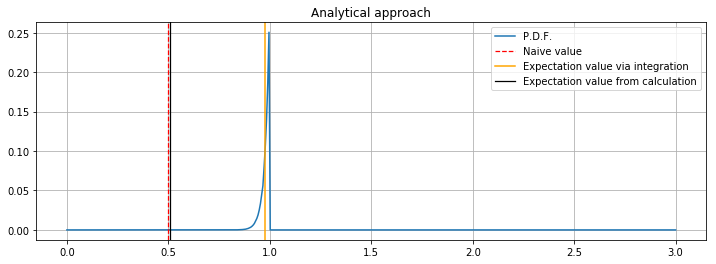

Black and orange line coincide for infinite histogram.


In [301]:
w = np.linspace(0, 3, 501)
p = custom_pdf_ratio(n_veto_hits_mdom, n_veto_hits_pdom, n_hits, n_hits, w)
mode_val = max(p)
mode_mask = np.array([val == mode_val for val in p])
mode = float(w[mode_mask])

cp = custom_cumulative_pdf_ratio(n_veto_hits_mdom, n_veto_hits_pdom, n_hits, n_hits, w)
# scale down cp
cp_scaled = cp / 100
norm = np.nansum(p)
p = p/norm

expect_analytic = np.dot(w, p)
print('Expectation value via integration: ' + str(expect_analytic))

naive_expect = (n_hits - n_veto_hits_mdom)/(n_hits - n_veto_hits_pdom)
print('Naively expected value: ' + str(naive_expect))

expect_pass_rat = ((n_hits - n_veto_hits_mdom)*(n_hits - 1)/(n_hits*(n_hits - n_veto_hits_pdom - 1)))

plt.plot(w, p, label = 'P.D.F.')
#plt.plot(w, cp_scaled, label = '0.01 * C.D.F.')
plt.rcParams['figure.figsize'] = (12, 4)
plt.grid(True)
plt.title('Analytical approach')
plt.axvline(x = naive_expect, linewidth = 1.25, color = 'red', linestyle = '--', label = 'Naive value')
plt.axvline(x = expect_analytic, linewidth = 1.5, color = 'orange', label = 'Expectation value via integration')
plt.axvline(x = expect_pass_rat, linewidth = 1.25, color = 'k', label = 'Expectation value from calculation')
plt.legend(loc = 'best')
plt.show()
print('Black and orange line coincide for infinite histogram.')

## <font color='orange'>Numerical approach</font>

Remove 0- and 1- bin due to problems of beta distribution.

In [242]:
res = 1000

n_veto_hits_mdom = float(n_veto_hits_mdom)
n_veto_hits_pdom = float(n_veto_hits_pdom)
n_hits = float(n_hits)

veto_efficiency_mdom = n_veto_hits_mdom / n_hits
veto_efficiency_pdom = n_veto_hits_pdom / n_hits

e = np.linspace(0, 1, res + 1)
e = e[1:-1]

p_mdom = np.array([prob_dist_beta(ei, n_veto_hits_mdom, n_hits) for ei in e])
p_pdom = np.array([prob_dist_beta(ei, n_veto_hits_pdom, n_hits) for ei in e])

p_inv_mdom = np.array([prob_dist_beta(1.0-ei, n_veto_hits_mdom, n_hits) for ei in e])
p_inv_pdom = np.array([prob_dist_beta(1.0-ei, n_veto_hits_pdom, n_hits) for ei in e])

Numerical procedure calculating the 90% errors on veto efficiencies of pDOM and mDOM. Then calculating the maximal possible (and over-estimated) error ($[\frac{1-\eta_{mDOM}-\Delta_{mDOM\downarrow}}{1-\eta_{pDOM}+\Delta_{pDOM\uparrow}}, \frac{1-\eta_{mDOM}+\Delta_{mDOM\uparrow}}{1-\eta_{pDOM}-\Delta_{pDOM\downarrow}}]$).

In [243]:
error_size = 0.9
step_size = 0.0001 # for better precision 0.00001 or even smaller

def num_error(eta, vetohits, nhits = n_hits, errorsize = error_size, stepsize = step_size):
    if eta < 0.5:
        low = 0.0
        top = 1.0 - stepsize
    elif eta >= 0.5:
        low = 0.0 + stepsize
        top = 1.0

    interval = 1.0

    while interval >= errorsize:
        low_p = prob_dist_beta(low, vetohits, nhits)
        top_p = prob_dist_beta(top, vetohits, nhits)
        low_cp = sp.special.betainc(vetohits+1, nhits-vetohits+1, low)
        top_cp = sp.special.betainc(vetohits+1, nhits-vetohits+1, top)
        interval = top_cp - low_cp
        if low_p > top_p:
            top = top - stepsize
        else:
            low = low + stepsize
    return low, top

low_pdom, top_pdom = num_error(veto_efficiency_pdom, n_veto_hits_pdom)
low_mdom, top_mdom = num_error(veto_efficiency_mdom, n_veto_hits_mdom)
        
delta_low_pdom = veto_efficiency_pdom - low_pdom
delta_top_pdom = top_pdom - veto_efficiency_pdom
delta_low_mdom = veto_efficiency_mdom - low_mdom
delta_top_mdom = top_mdom - veto_efficiency_mdom

ratio = (1-veto_efficiency_mdom)/(1-veto_efficiency_pdom)
over_error_top = (1-low_mdom)/(1-top_pdom)
over_error_low = (1-top_mdom)/(1-low_pdom)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Same procedure for the passing ratio error

In [244]:
def pass_rat_num_error(start, nvetohitsmdom = n_veto_hits_mdom, nvetohitspdom = n_veto_hits_pdom, nhits = n_hits, errorsize = error_size, stepsize = step_size):
    if start < stepsize:
        low = 0
    else:
        low = start - stepsize
    top = start + stepsize
    
    interval = 0.0
    
    while interval < errorsize:
        low_p = custom_pdf_ratio(nvetohitsmdom, nvetohitspdom, nhits, nhits, low)
        top_p = custom_pdf_ratio(nvetohitsmdom, nvetohitspdom, nhits, nhits, top)
        low_cp = custom_cumulative_pdf_ratio(nvetohitsmdom, nvetohitspdom, nhits, nhits, low)
        top_cp = custom_cumulative_pdf_ratio(nvetohitsmdom, nvetohitspdom, nhits, nhits, top)
        interval = top_cp - low_cp
        if low_p > top_p:
            low = low - stepsize
        else:
            top = top + stepsize
    return low, top

low_pr, top_pr = pass_rat_num_error(mode)

'''Not sure if this is right... maybe mode - low_pf and top_pf - mode?'''
delta_low_pr = expect_pass_rat - low_pr
delta_top_pr = top_pr - expect_pass_rat
print(delta_low_pr, delta_top_pr)

0.5834999999999866 0.587399999999899


Plot the beta distributions of $\eta_{pDOM}$ and $\eta_{mDOM}$ with corresponding error range.

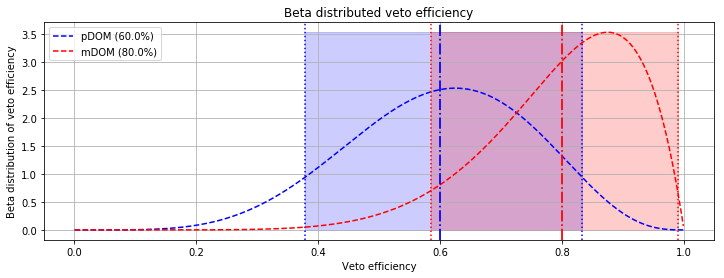

In [245]:
plt.title('Beta distributed veto efficiency')
plt.rcParams['figure.figsize'] = (12, 4)
plt.plot(e, p_pdom, '--', label = 'pDOM ({}%)'.format(100*veto_efficiency_pdom), color = 'blue')
plt.axvline(x = low_pdom, ymin = 0, ymax = 8, ls = ':', linewidth = 1.5, color = 'blue')
plt.axvline(x = top_pdom, ymin = 0, ymax = 8, ls = ':', linewidth = 1.5, color = 'blue')
plt.plot(e, p_mdom, '--', label = 'mDOM ({}%)'.format(100*veto_efficiency_mdom), color = 'red')
plt.axvline(x = low_mdom, ymin = 0, ymax = 8, ls = ':', linewidth = 1.5, color = 'red')
plt.axvline(x = top_mdom, ymin = 0, ymax = 8, ls = ':', linewidth = 1.5, color = 'red')

plt.xlabel('Veto efficiency')
plt.ylabel('Beta distribution of veto efficiency')

plt.axvline(x=veto_efficiency_pdom, ls='-.', linewidth = 1.75, color = 'blue')
plt.axvline(x=veto_efficiency_mdom, ls='-.', linewidth = 1.75, color = 'red')
maxim = np.amax([np.amax(p_pdom), np.amax(p_mdom)])
plt.fill_between([low_pdom, top_pdom], [0, 0], maxim, color = 'blue', alpha = 0.2)
plt.fill_between([low_mdom, top_mdom], [0, 0], maxim, color = 'red', alpha = 0.2)

plt.legend(loc = 'best')
plt.grid(True)
#plt.savefig('single_distributions.png')
plt.show()

Iterate over all combinations of bins from pDOM and mDOM distribution, store corresponding passing ratio and weighting.

In [246]:
val_ = []
wei_ = []

for a1 in range(res-1):
    for a2 in range(res-1):
        va = 1.0*e[a1]/e[a2]
        we = 1.0*p_inv_mdom[a1]*p_inv_pdom[a2]
        if np.isnan(va) or np.isinf(va) or np.isnan(we) or np.isinf(we):
            continue
        else:
            val_.append(va)
            wei_.append(we)

val_ = np.array(val_)
wei_ = np.array(wei_)

Here take a random segmentation of the [0, 1] interval and do the same iteration as above with the random values (should avoid the peaks at prominant rational values (1, 0.5, 2, 1.5, ...)).

In [247]:
val = []
wei = []

np.random.seed(42)
e1 = np.random.uniform(0, 1, res)
np.random.seed(1337)
e2 = np.random.uniform(0, 1, res)

p_1 = np.array([prob_dist_beta(1.0-e1i, n_veto_hits_mdom, n_hits) for e1i in e1])
p_2 = np.array([prob_dist_beta(1.0-e2i, n_veto_hits_pdom, n_hits) for e2i in e2])

for a1 in range(len(e1)):
    for a2 in range(len(e2)):
        va = 1.0*e1[a1]/e2[a2]
        we = 1.0*p_1[a1]*p_2[a2]
        if np.isnan(va) or np.isinf(va) or np.isnan(we) or np.isinf(we):
            continue
        else:
            val.append(va)
            wei.append(we)
            
val = np.array(val)
wei = np.array(wei)

Difference between expectation value and integrated mean:
-0.0216854134608


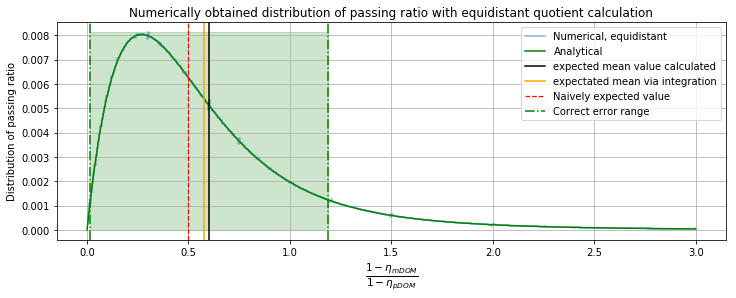

Black and orange line coincide for infinite histogram.


In [248]:
reso = 501

bins = np.linspace(0,3,reso)
hist, bin_edges = np.histogram(val_, bins = bins, weights=wei_)
norm = np.sum(hist)
hist = hist/norm
bin_centers = (bins[:-1] + bins[1:])/2

expect_numeric = np.dot(bin_centers, hist)

#expect_pass_rat = ((n_hits - n_veto_hits_mdom)*(n_hits - 1)/(n_hits*(n_hits - n_veto_hits_pdom - 1)))

print('Difference between expectation value and integrated mean:')
print(expect_numeric - expect_pass_rat)

plt.title('Numerically obtained distribution of passing ratio with equidistant quotient calculation')
plt.xlabel(r'$\frac{1-\eta_{mDOM}}{1-\eta_{pDOM}}$', fontsize = 15)
plt.ylabel('Distribution of passing ratio')
plt.step(bin_centers, hist, where = 'mid', label = 'Numerical, equidistant', alpha = 0.5)
plt.plot(w ,p, color = 'green', label = 'Analytical')
plt.axvline(x = expect_pass_rat, ymin = 0, ymax = 1, linewidth = 1.5, color = 'k', label = 'expected mean value calculated')
plt.axvline(x = expect_numeric, ymin = 0, ymax = 1, linewidth = 1.5, color = 'orange', label = 'expectated mean via integration')
plt.axvline(x = naive_expect, ymin = 0, ymax = 1, linewidth = 1.25, color = 'red', linestyle = '--', label = 'Naively expected value')
#plt.axvline(x = over_error_low, ymin = 0, ymax = 1, linewidth = 1.5, color = 'k', alpha = 0.5, label = 'overestimated error range')
#plt.axvline(x = over_error_top, ymin = 0, ymax = 1, linewidth = 1.5, color = 'k', alpha = 0.5)
plt.axvline(x = low_pf, ymin = 0, ymax = 1, linewidth = 1.5, color = 'green', alpha = 1, linestyle = '-.', label = 'Correct error range')
plt.axvline(x = top_pf, ymin = 0, ymax = 1, linewidth = 1.5, color = 'green', alpha = 1, linestyle = '-.')
maxim_pr = max(hist)
plt.fill_between([low_pr, top_pr], [0, 0], maxim_pr, color = 'green', alpha = 0.2)

plt.legend(loc = 'best')
plt.grid(True)
#plt.savefig('num_ratio.png')
plt.show()
print('Black and orange line coincide for infinite histogram.')

Difference between expectation value and integrated mean:
-0.0396848973636


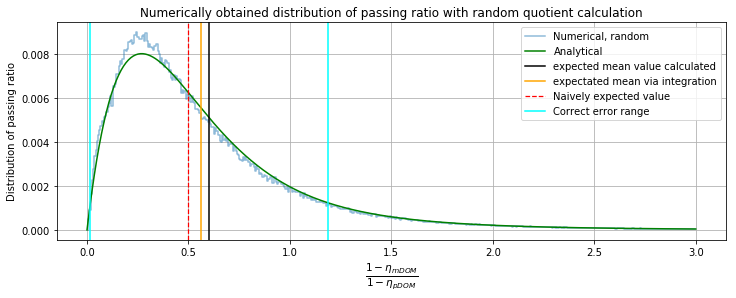

In [249]:
bins = np.linspace(0,3,reso)
hist, bin_edges = np.histogram(val, bins = bins, weights=wei)
norm = np.sum(hist)
hist = hist/norm

bin_centers = (bins[:-1] + bins[1:])/2

expect_numeric_rand = np.dot(bin_centers, hist)

print('Difference between expectation value and integrated mean:')
print(expect_numeric_rand - expect_pass_rat)

plt.title('Numerically obtained distribution of passing ratio with random quotient calculation')
plt.xlabel(r'$\frac{1-\eta_{mDOM}}{1-\eta_{pDOM}}$', fontsize = 15)
plt.ylabel('Distribution of passing ratio')
plt.step(bin_centers,hist, where = 'mid', label = 'Numerical, random', alpha = 0.5)
plt.plot(w,p, color = 'green', label = 'Analytical')
plt.axvline(x = expect_pass_rat, ymin = 0, ymax = 1, linewidth = 1.5, color = 'k', label = 'expected mean value calculated')
plt.axvline(x = expect_numeric_rand, ymin = 0, ymax = 1, linewidth = 1.5, color = 'orange', label = 'expectated mean via integration')
plt.axvline(x = naive_expect, ymin = 0, ymax = 1, linewidth = 1.25, color = 'red', linestyle = '--', label = 'Naively expected value')
#plt.axvline(x = over_error_low, ymin = 0, ymax = 1, linewidth = 1.5, color = 'k', alpha = 0.5)
#plt.axvline(x = over_error_top, ymin = 0, ymax = 1, linewidth = 1.5, color = 'k', alpha = 0.5, label = 'overestimated error range')
plt.axvline(x = low_pr, ymin = 0, ymax = 1, linewidth = 1.5, color = 'cyan', alpha = 1, label = 'Correct error range')
plt.axvline(x = top_pr, ymin = 0, ymax = 1, linewidth = 1.5, color = 'cyan', alpha = 1)

plt.legend(loc = 'best')
plt.grid(True)
#plt.savefig('num_ratio_rand.png')
plt.show()